<a href="https://colab.research.google.com/github/lingliao/Machine-learning-model/blob/main/BLUEPRINT_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import itertools
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import subprocess


In [2]:
def runlinuxcmd(cmd, verbose = False, *args, **kwargs):
    print(cmd)
    process = subprocess.Popen(
        cmd,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text = True,
        shell = True
    )
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(),std_err)
    pass

In [3]:
# Annotations & bs_cov / bs_call names
CELL_TYPE_TO_FILE_ID = {
    # CD4
    "T_cells_CD4_naive": ["S009W451", "S008H151","S007DD51","P580","P582","P584","P586","S007G756"],
    "T_cells_CD4_CM": ["S006YC51", "S014QS55"],
    "T_cells_CD4_EM": ["S001U352", "S014QS51"],
    "T_cells_CD4_Tregs": ["S00XTP51","S001U353"],
    
    # CD8
    "T_cells_CD8_naive": ["C0066P51","C003VO55","C00256A1bs","S00C2F51"],
    "T_cells_CD8_CM": ["C003VO56", "C005UI52"],
    "T_cells_CD8_EM": ["C00256A3bs", "S014WG51"],
    "T_cells_CD8_EMRA": ["S002ND51", "S0164R51"],

    # B cells
    "B_cells_naive": ["S01ECGA1","NBC_NC11_83","NBC_NC11_41","S001JP51","C003K951","S00DM851","C0068L51"],
    "B_cells_memory": ["S017RE51","C003N351"], # Excluding W653; few reads.

    "Plasma_cells": ["bmPCs-V156","G202","PC_T12_20","PC_T13_1","PC_T14_10"],
    # Archived plasma cells (previously used): ["S00XCMA1","S00XDKU1","S00XEIU1","G204","G203"],

    # Monocyte/Macrophage
    "Monocytes": ["S01BBUA1","C005PS51","S000RD54","C000S5A1bs","C0010KA2bs","C001UYA3bs", "C004SQ51", "S00V2DN1",  "S01E03A1", "S01MAPA1", "S01B47A1", "S01B71A1", "S01BEOA1", "S01BHIA1",  "S01B63A1", "S01BDQA1", "S01BGKA1", "S01BAWA1", "S01B55A1", "S01BCSA1", "S01B9YA1", "S01BFMA1"],
    "Macrophages_M0": ["S001S751","S0039051","S0022I51","S00BHQ51","S00DVR51","C005VG51"],
    "Macrophages_M1": ["S0022I53","S001S753","S0018A52","S00H6O51","S007SK51","S001MJ51"],
    "Macrophages_M2": ["S00BS451","S0062252","S00FTN51","S00C1H51","S00E8W51","S006VI53"],

    "NK_cells": ["C0067N51","S01E8O51","C002CTA1bs","C006G551"],
    "Neutrophils": ["S00K5EA1","C00184A3bs","C001UYA1bs","C0010KA1bs","C004GD51","C0011IA3bs","C000S5A2bs","S00FWHA1","S00K7AA1"],
    "Eosinophils": ["S00V6553","S006XE53"],

    "Dendritic_cells_immature": ["S00TU2A1", "S00TV0A1"],
    "Dendritic_cells_mature": ["S00TXXA1", "S00TYVA1"],

    "Megakaryocytes": ["S004AV51", "S004BT51"],
    "Erythroblasts": ["S002S351","S002R551"]
}

FILE_ID_TO_CELL_TYPE = {sample:cell_type for cell_type, sample_list in CELL_TYPE_TO_FILE_ID.items() for sample in sample_list}
BLUEPRINT_FILEKEYS = list(itertools.chain.from_iterable(CELL_TYPE_TO_FILE_ID.values()))
sample_list = [idx for idx in [CELL_TYPE_TO_FILE_ID[key] for key in CELL_TYPE_TO_FILE_ID]]
sample_list = [item for sublist in sample_list for item in sublist]

print(f"Number of Blueprint cell types: {len(CELL_TYPE_TO_FILE_ID.keys())}")
print(f"Number of Blueprint raw files: {len(BLUEPRINT_FILEKEYS)}")

Number of Blueprint cell types: 22
Number of Blueprint raw files: 101


In [4]:
fin = '/content/blueprint_files.tsv'
df = pd.read_csv(fin,sep='\t')

In [5]:
url_list = [url for url in df['URL'] if 'CPG_methylation_calls.bs_call' in url]
url_list = [url for url in url_list if any(sample_idx in url for sample_idx in sample_list)]

df.index = df['URL']
df = df.loc[url_list,:]
df.index = [i for i in range(len(df))]
df['LTME_SampleID'] = [url.split('/')[-1].split('.')[0] for url in df['URL']]
df['LTME_CellType'] = [FILE_ID_TO_CELL_TYPE[sample_idx] for sample_idx in df['LTME_SampleID']]

df2 = pd.read_csv(fin,sep='\t')

url_list = [url for url in df2['URL'] if 'CPG_methylation_calls.bs_cov' in url]
url_list = [url for url in url_list if any(sample_idx in url for sample_idx in sample_list)]

df2.index = df2['URL']
df2 = df2.loc[url_list,:]
df2.index = [i for i in range(len(df2))]
df2['LTME_SampleID'] = [url.split('/')[-1].split('.')[0] for url in df2['URL']]
df2['LTME_CellType'] = [FILE_ID_TO_CELL_TYPE[sample_idx] for sample_idx in df2['LTME_SampleID']]

df.index = df['LTME_SampleID']
df2.index = df2['LTME_SampleID']
df2 = df2.loc[df.index,:]

df = df.rename(columns={'URL':'URL_main'})
df2 = df2.rename(columns={'URL':'URL_coverage'})
df['URL_coverage'] = df2['URL_coverage'].copy()

In [6]:
!mkdir /content/input

In [7]:
df.to_csv('/content/input/blueprint_data_overview.csv',index=False)

In [8]:
df2.to_csv('/content/input/blueprint_data_overview_extended.csv',index=False)

# Download methylation signal files

In [9]:
!mkdir /content/MethylationSignal

In [10]:
dir_out = "/content/MethylationSignal"
cmd_list = ["wget -P "+dir_out+" "+fin_dl for fin_dl in list(df['URL_main'])]

In [11]:
process_cap = 8
with Pool(process_cap) as p:
    p.map(runlinuxcmd,cmd_list)
    p.close()
    p.join()

wget -P /content/MethylationSignal http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/venous_blood/C000S5/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/C000S5A1bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bwwget -P /content/MethylationSignal http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/venous_blood/C0010K/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/C0010KA2bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bwwget -P /content/MethylationSignal http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/cord_blood/S000RD/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/S000RD54.CPG_methylation_calls.bs_call.GRCh38.20160531.bwwget -P /content/MethylationSignal http://ftp.ebi.ac.uk/pub/databases/blueprint/data/homo_sapiens/GRCh38/cord_blood/C005PS/CD14-positive_CD16-negative_classical_monocyte/Bisulfite-Seq/CNAG/C005PS51.CPG_methylation_calls.bs_call.GRCh38.20160531.bwwget -P 

In [12]:
#Another three from Grail
!wget -P /content/MethylationSignal https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5652nnn/GSM5652302/suppl/GSM5652302_Blood-Monocytes-Z000000TP.hg38.bigwig
!wget -P /content/MethylationSignal https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5652nnn/GSM5652303/suppl/GSM5652303_Blood-Monocytes-Z000000U3.hg38.bigwig
!wget -P /content/MethylationSignal https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5652nnn/GSM5652304/suppl/GSM5652304_Blood-Monocytes-Z000000UH.hg38.bigwig

--2023-05-03 15:27:42--  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5652nnn/GSM5652302/suppl/GSM5652302_Blood-Monocytes-Z000000TP.hg38.bigwig
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.228, 165.112.9.229, 2607:f220:41e:250::7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256492981 (245M)
Saving to: ‘/content/MethylationSignal/GSM5652302_Blood-Monocytes-Z000000TP.hg38.bigwig’

GSM5652302_Blood-Mo 100%[===================>] 244.61M  76.0MB/s    in 3.2s    

2023-05-03 15:27:46 (76.0 MB/s) - ‘/content/MethylationSignal/GSM5652302_Blood-Monocytes-Z000000TP.hg38.bigwig’ saved [256492981/256492981]

--2023-05-03 15:27:46--  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5652nnn/GSM5652303/suppl/GSM5652303_Blood-Monocytes-Z000000U3.hg38.bigwig
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.228, 165.112.9.229, 2607:f220:41e:250::7, ...
Connecting to

In [13]:
#convert .bw to .bed
!pip install pyBigWig
!mkdir /content/MethylationSignal/BedGraph

import os
import pyBigWig

# Set the input and output folder paths
input_folder = '/content/MethylationSignal'
output_folder = '/content/MethylationSignal/BedGraph'

import os
import pyBigWig

def convert_bw_files_to_bed(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.endswith(".bw"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename.replace(".bw", ".bed"))
            convert_bw_to_bed(input_path, output_path)

def convert_bigwig_files_to_bed(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.endswith(".bigwig"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename.replace(".bigwig", ".bed"))
            convert_bw_to_bed(input_path, output_path)

def convert_bw_to_bed(input_file, output_file):
    bw = pyBigWig.open(input_file)
    with open(output_file, 'w') as f:
        for chrom, length in bw.chroms().items():
            for start, end, value in bw.intervals(chrom):
                f.write(f"{chrom}\t{start}\t{end}\t{value}\n")
    bw.close()

convert_bw_files_to_bed(input_folder, output_folder)
convert_bigwig_files_to_bed(input_folder, output_folder)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.4 MB/s eta 0:00:00


## make all the files

In [14]:
!mkdir = "/content/MethylationSignal/sorted"
!mkdir = "/content/MethylationSignal/sorted/intersect_k100"
!mkdir = "/content/MethylationSignal/sorted/intersect_weighted"

mkdir: cannot create directory ‘=’: File exists
mkdir: cannot create directory ‘=’: File exists


## sort

In [15]:
#install bedtools
!apt-get install bedtools
!bedtools --version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 580 kB of archives.
After this operation, 2,055 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 bedtools amd64 2.27.1+dfsg-4ubuntu1 [580 kB]
Fetched 580 kB in 0s (1,744 kB/s)
Selecting previously unselected package bedtools.
(Reading database ... 122518 files and directories currently installed.)
Preparing to unpack .../bedtools_2.27.1+dfsg-4ubuntu1_amd64.deb ...
Unpacking bedtools (2.27.1+dfsg-4ubuntu1) ...
Setting up bedtools (2.27.1+dfsg-4ubuntu1) ...
bedtools v2.27.1


In [16]:
import os
from multiprocessing import Pool

input = "/content/MethylationSignal/BedGraph"
output_sort = "/content/MethylationSignal/sorted"

def run_linux_command(input_path):
    filename = os.path.basename(input_path)
    output_path = os.path.join(output_sort, filename)
    cmd = f"bedtools sort -i {input_path} > {output_path}"
    print(cmd) 
    os.system(cmd)

# Get a list of input file paths
input_paths = []
for filename in os.listdir(input):
    if filename.endswith(".bed"):
        input_path = os.path.join(input, filename)
        input_paths.append(input_path)

# maximum number of processes to run in parallel
process_cap = 1 
# Run the Linux command on each input file in parallel
with Pool(process_cap) as pool:
    pool.map(run_linux_command, input_paths)
    pool.close()
    pool.join()

bedtools sort -i /content/MethylationSignal/BedGraph/C004SQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bed > /content/MethylationSignal/sorted/C004SQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bed
bedtools sort -i /content/MethylationSignal/BedGraph/C001UYA3bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed > /content/MethylationSignal/sorted/C001UYA3bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed
bedtools sort -i /content/MethylationSignal/BedGraph/S00V2DN1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed > /content/MethylationSignal/sorted/S00V2DN1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed
bedtools sort -i /content/MethylationSignal/BedGraph/S01B71A1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed > /content/MethylationSignal/sorted/S01B71A1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed
bedtools sort -i /content/MethylationSignal/BedGraph/S01E03A1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed > /content/MethylationSignal/sorted/S01E03A1.CPG_methyla

## Perform intersection

In [17]:
#for monocyte only
from functools import partial

input_folder = "/content/MethylationSignal/sorted"
output_folder = "/content/MethylationSignal/sorted/intersect_weighted"
#only monocyte position
map_path = "/content/Monocytes.bed" 

def bed_intersect(input_path, map_path, output_path):
    filename = os.path.basename(input_path)
    output_path = os.path.join(output_path, filename)
    cmd = f"bedtools intersect -f 1 -F 1 -a {input_path} -b {map_path} > {output_path}"
    print(cmd) 
    os.system(cmd)

# Get a list of input file paths
input_paths = []
for filename in os.listdir(input_folder):
    if filename.endswith(".bed"):
        input_path = os.path.join(input_folder, filename)
        input_paths.append(input_path)



# maximum number of processes to run in parallel
process_cap = 1
# Run the Linux command on each input file in parallel
with Pool(process_cap) as pool:
    func = partial(bed_intersect, map_path = map_path, output_path = output_folder)
    pool.map(func, input_paths)
    pool.close()
    pool.join()

bedtools intersect -f 1 -F 1 -a /content/MethylationSignal/sorted/C004SQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bed -b /content/Monocytes.bed > /content/MethylationSignal/sorted/intersect_weighted/C004SQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bed
bedtools intersect -f 1 -F 1 -a /content/MethylationSignal/sorted/C001UYA3bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed -b /content/Monocytes.bed > /content/MethylationSignal/sorted/intersect_weighted/C001UYA3bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed
bedtools intersect -f 1 -F 1 -a /content/MethylationSignal/sorted/S00V2DN1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed -b /content/Monocytes.bed > /content/MethylationSignal/sorted/intersect_weighted/S00V2DN1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed
bedtools intersect -f 1 -F 1 -a /content/MethylationSignal/sorted/S01B71A1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed -b /content/Monocytes.bed > /content/MethylationSignal/sorted/intersect_weig

In [18]:
#for all cell type positions
!mkdir = "/content/MethylationSignal/sorted/intersect_all"
output_folder = "/content/MethylationSignal/sorted/intersect_all"
#all position
map_path = "/content/weighted_all.bed" 

# maximum number of processes to run in parallel
process_cap = 1
# Run the Linux command on each input file in parallel
with Pool(process_cap) as pool:
    func = partial(bed_intersect, map_path = map_path, output_path = output_folder)
    pool.map(func, input_paths)
    pool.close()
    pool.join()

mkdir: cannot create directory ‘=’: File exists
bedtools intersect -f 1 -F 1 -a /content/MethylationSignal/sorted/C004SQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bed -b /content/weighted_all.bed > /content/MethylationSignal/sorted/intersect_all/C004SQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bed
bedtools intersect -f 1 -F 1 -a /content/MethylationSignal/sorted/C001UYA3bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed -b /content/weighted_all.bed > /content/MethylationSignal/sorted/intersect_all/C001UYA3bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed
bedtools intersect -f 1 -F 1 -a /content/MethylationSignal/sorted/S00V2DN1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed -b /content/weighted_all.bed > /content/MethylationSignal/sorted/intersect_all/S00V2DN1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed
bedtools intersect -f 1 -F 1 -a /content/MethylationSignal/sorted/S01B71A1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed -b /content/weighted_all.bed > /co

## Perform average methylation level analysis

In [19]:
!mkdir = "/content/MethylationSignal/sorted/average_methylation_level"

from functools import partial

output_folder = "/content/MethylationSignal/sorted/average_methylation_level"
map_path = "/content/hr38_upstream1000_withgenename_cleaned.sorted.rmNA.bed"

def bed_map(input_path, map_path, output_path):
    filename = os.path.basename(input_path)
    output_path = os.path.join(output_path, filename)
    cmd = f"bedtools map -b {input_path} -a {map_path} -c 4 -o mean > {output_path}"
    print(cmd) 
    os.system(cmd)

# maximum number of processes to run in parallel
process_cap = 1
# Run the Linux command on each input file in parallel
with Pool(process_cap) as pool:
    func = partial(bed_map, map_path = map_path, output_path = output_folder)
    pool.map(func, input_paths)
    pool.close()
    pool.join()

mkdir: cannot create directory ‘=’: File exists
bedtools map -b /content/MethylationSignal/sorted/C004SQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bed -a /content/hr38_upstream1000_withgenename_cleaned.sorted.rmNA.bed -c 4 -o mean > /content/MethylationSignal/sorted/average_methylation_level/C004SQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bed
bedtools map -b /content/MethylationSignal/sorted/C001UYA3bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed -a /content/hr38_upstream1000_withgenename_cleaned.sorted.rmNA.bed -c 4 -o mean > /content/MethylationSignal/sorted/average_methylation_level/C001UYA3bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed
bedtools map -b /content/MethylationSignal/sorted/S00V2DN1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed -a /content/hr38_upstream1000_withgenename_cleaned.sorted.rmNA.bed -c 4 -o mean > /content/MethylationSignal/sorted/average_methylation_level/S00V2DN1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed
bedtools map -b /c

## Case study

In [18]:
#convert .bw to .bed
!pip install pyBigWig
!mkdir /content/MethylationSignal/BedGraph

import os
import pyBigWig

# Set the input and output folder paths
input_folder = '/content/MethylationSignal'
output_folder = '/content/MethylationSignal/BedGraph'

import os
import pyBigWig

def convert_bw_files_to_bed(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.endswith(".bw"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename.replace(".bw", ".bed"))
            convert_bw_to_bed(input_path, output_path)

def convert_bw_to_bed(input_file, output_file):
    bw = pyBigWig.open(input_file)
    with open(output_file, 'w') as f:
        for chrom, length in bw.chroms().items():
            for start, end, value in bw.intervals(chrom):
                f.write(f"{chrom}\t{start}\t{end}\t{value}\n")
    bw.close()
convert_bw_files_to_bed(input_folder, output_folder)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.5 MB/s eta 0:00:00


In [22]:


def convert_bw_files_to_bed(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.endswith(".bigwig"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename.replace(".bigwig", ".bed"))
            convert_bw_to_bed(input_path, output_path)

def convert_bw_to_bed(input_file, output_file):
    bw = pyBigWig.open(input_file)
    with open(output_file, 'w') as f:
        for chrom, length in bw.chroms().items():
            for start, end, value in bw.intervals(chrom):
                f.write(f"{chrom}\t{start}\t{end}\t{value}\n")
    bw.close()
convert_bw_files_to_bed(input_folder, output_folder)

In [ ]:
#install bedtools
!apt-get install bedtools
!bedtools --version

In [34]:
import os
from multiprocessing import Pool

input = "/content/MethylationSignal/BedGraph"
output_sort = "/content/MethylationSignal/sorted"

def run_linux_command(input_path):
    filename = os.path.basename(input_path)
    output_path = os.path.join(output_sort, filename)
    cmd = f"bedtools sort -i {input_path} > {output_path}"
    print(cmd) 
    os.system(cmd)

# Get a list of input file paths
input_paths = []
for filename in os.listdir(input):
    if filename.endswith(".bed"):
        input_path = os.path.join(input, filename)
        input_paths.append(input_path)

# maximum number of processes to run in parallel
process_cap = 1 
# Run the Linux command on each input file in parallel
with Pool(process_cap) as pool:
    pool.map(run_linux_command, input_paths)
    pool.close()
    pool.join()

bedtools sort -i /content/MethylationSignal/BedGraph/GSM5652302_Blood-Monocytes-Z000000TP.bed > /content/MethylationSignal/sorted/GSM5652302_Blood-Monocytes-Z000000TP.bed
bedtools sort -i /content/MethylationSignal/BedGraph/C000S5A1bs.CPG_methylation_calls.bs_cov.GRCh38.20160531.bed > /content/MethylationSignal/sorted/C000S5A1bs.CPG_methylation_calls.bs_cov.GRCh38.20160531.bed
bedtools sort -i /content/MethylationSignal/BedGraph/GSM5652302_Blood-Monocytes-Z000000TP.hg38.bed > /content/MethylationSignal/sorted/GSM5652302_Blood-Monocytes-Z000000TP.hg38.bed


In [28]:
ll = "/content/MethylationSignal/BedGraph/GSM5652302_Blood-Monocytes-Z000000TP.hg38.bed"
bed_data = pd.read_csv(ll, sep="\t",header = None, names=['Chr', 'Start', 'End','Level'])

In [36]:
#case study
!bedtools intersect -f 1 -F 1 -a /content/MethylationSignal/sorted/C000S5A1bs.CPG_methylation_calls.bs_cov.GRCh38.20160531.bed -b /content/MethylationSignal/sorted/GSM5652302_Blood-Monocytes-Z000000TP.bed > test_intersect.bed

In [37]:
#case study
!bedtools intersect -f 1 -F 1 -a /content/MethylationSignal/sorted/C000S5A1bs.CPG_methylation_calls.bs_cov.GRCh38.20160531.bed -b /content/MethylationSignal/sorted/GSM5652302_Blood-Monocytes-Z000000TP.hg38.bed > hg38_test_intersect.bed

In [42]:
ll = "/content/test_intersect.bed"

bed_data = pd.read_csv(ll, sep="\t",header = None, names=['Chr', 'Start', 'End','Level'])

blue = "/content/MethylationSignal/sorted/C000S5A1bs.CPG_methylation_calls.bs_cov.GRCh38.20160531.bed"
blue_data = pd.read_csv(blue, sep="\t",header = None,names=['Chr', 'Start', 'End','Level'])


grail = "/content/MethylationSignal/sorted/GSM5652302_Blood-Monocytes-Z000000TP.bed"
grail_data = pd.read_csv(grail, sep="\t",header = None,names=['Chr', 'Start', 'End','Level'])


In [43]:
bed_data.head()

,Chr,Start,End,Level
0,chr1,10468,10470,8.0
1,chr1,10470,10472,8.0
2,chr1,10483,10485,8.0
3,chr1,10488,10490,8.0
4,chr1,10492,10494,8.0


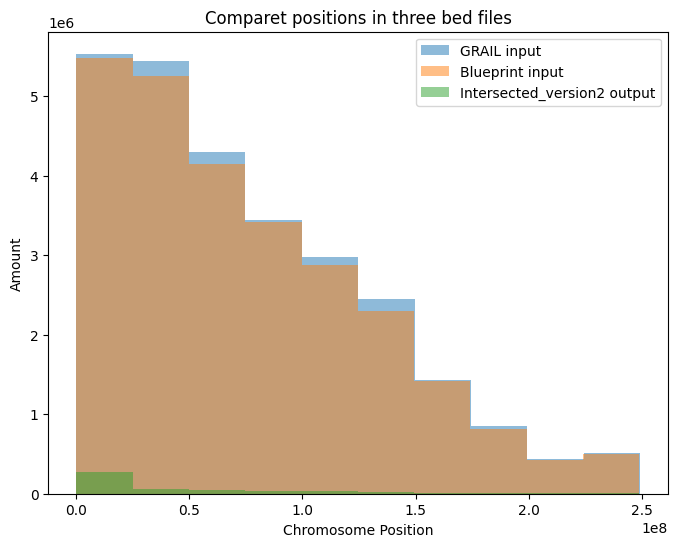

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# create the histogram
fig, ax = plt.subplots(figsize=(8, 6))



ax.hist(grail_data.iloc[:, 1], alpha=0.5, label='GRAIL input')
ax.hist(blue_data.iloc[:, 1], alpha=0.5, label='Blueprint input')
ax.hist(bed_data.iloc[:, 1], alpha=0.5, label='Intersected_version2 output')


ax.set_xlabel('Chromosome Position')
ax.set_ylabel('Amount')
ax.set_title('Comparet positions in three bed files')
ax.legend(loc='upper right')

#plt.savefig('case stydy - 1.jpg', dpi=700,bbox_inches='tight', pad_inches=0.1)
plt.show()

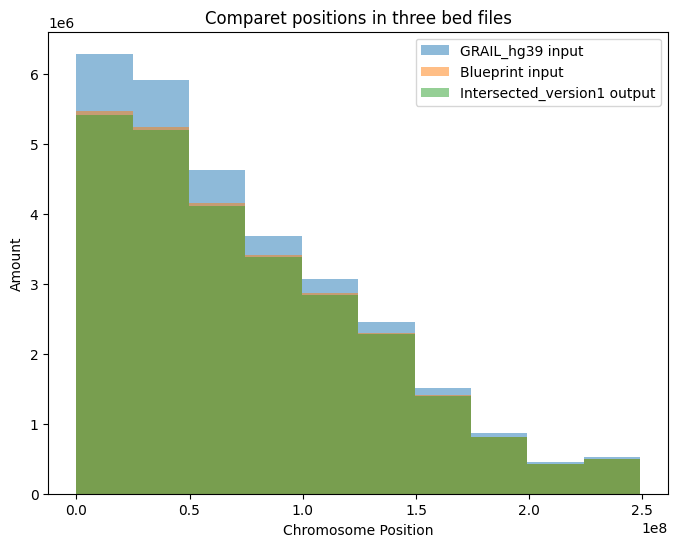

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# create the histogram
fig, ax = plt.subplots(figsize=(8, 6))



ax.hist(grail_data.iloc[:, 1], alpha=0.5, label='GRAIL_hg39 input')
ax.hist(blue_data.iloc[:, 1], alpha=0.5, label='Blueprint input')
ax.hist(bed_data.iloc[:, 1], alpha=0.5, label='Intersected_version1 output')


ax.set_xlabel('Chromosome Position')
ax.set_ylabel('Amount')
ax.set_title('Comparet positions in three bed files')
ax.legend(loc='upper right')

#plt.savefig('case stydy - 1.jpg', dpi=700,bbox_inches='tight', pad_inches=0.1)
plt.show()

In [257]:
merged_df_ = pd.merge(merged_df, grail_data, on='Start')

In [260]:
len(blue_data)

26627326

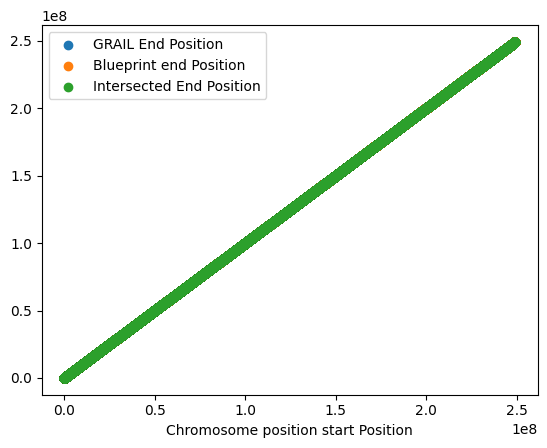

In [220]:
# create scatter plot with three y-values
plt.scatter(grail_data.iloc[:, 1], grail_data.iloc[:, 2])
plt.scatter(blue_data.iloc[:, 1], blue_data.iloc[:, 2])
plt.scatter(bed_data.iloc[:, 1], bed_data.iloc[:, 2])

# add x-axis label and legend
plt.xlabel('Chromosome position start Position')
plt.legend(['GRAIL End Position', 'Blueprint end Position', 'Intersected End Position'])

# show the plot
plt.show()

In [242]:
blue = "/content/MethylationSignal/sorted/intersect_weighted_monocytes/C000S5A1bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed"
blue_data = pd.read_csv(blue, sep="\t",header = None, names=['Chr', 'Start', 'End','Level'])

ll = "/content/Monocytes.bed"
bed_data = pd.read_csv(ll, sep="\t",header = None, names=['Chr', 'Start', 'End','Level'])

grail = "/content/MethylationSignal/sorted/intersect_weighted_monocytes/GSM5652302.Blood-Monocytes-Z000000TP.bed"
grail_data = pd.read_csv(grail, sep="\t",header = None, names=['Chr', 'Start', 'End','Level'])


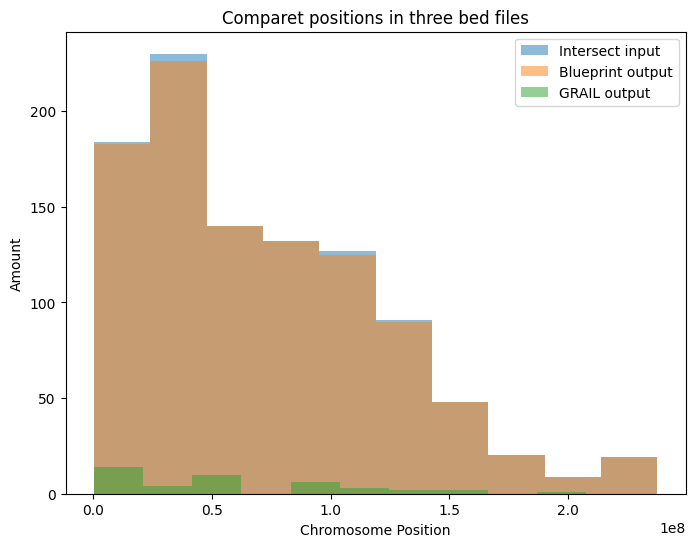

In [217]:
# create the histogram
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(bed_data.iloc[:, 1], alpha=0.5, label='Intersect input')
ax.hist(blue_data.iloc[:, 1], alpha=0.5, label='Blueprint output')
ax.hist(grail_data.iloc[:, 1], alpha=0.5, label='GRAIL output')

ax.set_xlabel('Chromosome Position')
ax.set_ylabel('Amount')
ax.set_title('Comparet positions in three bed files')
ax.legend(loc='upper right')

plt.savefig('case stydy - with monocytes_.jpg', dpi=700,bbox_inches='tight', pad_inches=0.1)
plt.show()

In [235]:
folder_path = "/content/MethylationSignal/sorted"

# iterate over all files in the folder
for filename in os.listdir(folder_path):
    # check if the file is a bed file
    if filename.endswith(".bed"):
        file_path = os.path.join(folder_path, filename)
        # read the file
        with open(file_path, "r") as file:
            # initialize variables
            total = 0
            count = 0
            # iterate over each line in the file
            for line in file:
                # split the line by tab and extract the fourth column
                fields = line.strip().split("\t")
                value = float(fields[3])
                # add the value to the total and increment the count
                total += value
                count += 1
            # calculate and print the average

            average = total / count
            print(f"{filename}: {average}")

S01B55A1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8166998225416942
S01BEOA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8205527659158619
S00V2DN1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.82467712816831
S01BFMA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.821757333755525
GSM5652304_Blood-Monocytes-Z000000UH.bed: 0.8030364362106598
S01BAWA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.812014696604835
C0010KA2bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8055859679892758
S01E03A1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8155986774969046
C000S5A1bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8145706481156868
S01BBUA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8171847293553572
S01B9YA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8167724122343456
C004SQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8195304436838617
S01B71A1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.81581325

In [233]:
folder_path = "/content/MethylationSignal/sorted/intersect_weighted_monocytes"

# iterate over all files in the folder
for filename in os.listdir(folder_path):
    # check if the file is a bed file
    if filename.endswith(".bed"):
        file_path = os.path.join(folder_path, filename)
        # read the file
        with open(file_path, "r") as file:
            # initialize variables
            total = 0
            count = 0
            # iterate over each line in the file
            for line in file:
                # split the line by tab and extract the fourth column
                fields = line.strip().split("\t")
                value = float(fields[3])
                # add the value to the total and increment the count
                total += value
                count += 1
            # calculate and print the average

            average = total / count
            print(f"{filename}: {average}")

S01B55A1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.5996623117907263
S01BEOA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.6236170855261872
S00V2DN1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.6816577044967659
S01BFMA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.7114128900611209
S01BAWA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.6032104736938697
C0010KA2bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8057691533786936
S01E03A1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.2296320001576096
GSM5652302.Blood-Monocytes-Z000000TP.bed: 0.8300095252870094
C000S5A1bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8062258060531495
S01BBUA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.6332479921248124
S01B9YA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.6055221321525978
GSM5652304.Blood-Monocytes-Z000000UH.bed: 0.8295428594574332
C004SQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.7977373853064958
GSM56

In [230]:
folder_path = "/content/MethylationSignal/sorted/intersect_weighted"

# iterate over all files in the folder
for filename in os.listdir(folder_path):
    # check if the file is a bed file
    if filename.endswith(".bed"):
        file_path = os.path.join(folder_path, filename)
        # read the file
        with open(file_path, "r") as file:
            # initialize variables
            total = 0
            count = 0
            # iterate over each line in the file
            for line in file:
                # split the line by tab and extract the fourth column
                fields = line.strip().split("\t")
                value = float(fields[3])
                # add the value to the total and increment the count
                total += value
                count += 1
            # calculate and print the average

            average = total / count
            print(f"{filename}: {average}")

S01B55A1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.9027825555258285
S01BEOA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8972984162747499
S00V2DN1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8924627934699971
S01BFMA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.9014087764573944
S01BAWA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8961775664992373
C0010KA2bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8945951308526018
S01E03A1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8791924973901224
GSM5652302.Blood-Monocytes-Z000000TP.bed: 0.8297555126264456
C000S5A1bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.9007304836688461
S01BBUA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.9042969343197027
S01B9YA1.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.901614978589011
GSM5652304.Blood-Monocytes-Z000000UH.bed: 0.8355793536525481
C004SQ51.CPG_methylation_calls.bs_call.GRCh38.20160531.bed: 0.8969857278433894
GSM565

## CD8 another source

In [ ]:
#CD8 TCM
!wget -P /content/another_source https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4293nnn/GSM4293893/suppl/GSM4293893_383227_methylation_value.bed.gz
!wget -P /content/another_source https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4293nnn/GSM4293894/suppl/GSM4293894_647761_methylation_value.bed.gz
!wget -P /content/another_source https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4293nnn/GSM4293895/suppl/GSM4293895_2-736134_methylation_value.bed.gz

#CD8 TEM
!wget -P /content/another_source https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4293nnn/GSM4293896/suppl/GSM4293896_383226_methylation_value.bed.gz
!wget -P /content/another_source https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4293nnn/GSM4293897/suppl/GSM4293897_647760_methylation_value.bed.gz
!wget -P /content/another_source https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4293nnn/GSM4293898/suppl/GSM4293898_2-736133_methylation_value.bed.gz


In [ ]:
!gunzip /content/another_source/*.gz

In [ ]:
!bedtools sort -i /content/another_source/GSM4293893_383227_methylation_value.bed > /content/another_source/GSM4293893_383227_methylation_value_.bed
!bedtools sort -i /content/another_source/GSM4293894_647761_methylation_value.bed  > /content/another_source/GSM4293894_647761_methylation_value_.bed
!bedtools sort -i /content/another_source/GSM4293895_2-736134_methylation_value.bed > /content/another_source/GSM4293895_2-736134_methylation_value_.bed

!bedtools sort -i /content/another_source/GSM4293896_383226_methylation_value.bed > /content/another_source/GSM4293896_383226_methylation_value_.bed
!bedtools sort -i /content/another_source/GSM4293897_647760_methylation_value.bed > /content/another_source/GSM4293897_647760_methylation_value_.bed
!bedtools sort -i /content/another_source/GSM4293898_2-736133_methylation_value.bed > /content/another_source/GSM4293898_2-736133_methylation_value_.bed

## data visualization k00

In [48]:
import itertools
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import subprocess

In [95]:
ll = "/content/MethylationSignal/sorted/average_methylation_level/C000S5A1bs.CPG_methylation_calls.bs_call.GRCh38.20160531.bed"

bed_data = pd.read_csv(ll, sep="\t",header = None, names=['Chr', 'Start', 'End','Level'])

In [96]:
bed_data.head()

Chr  Start End           Level
chr1 10868 11868      DDX11L1      0   +    0.6648947408
     17436 18436    MIR6859-1      0   -    0.9561111099
     28553 29553  MIR1302-2HG      0   +  0.001257575738
     29365 30365    MIR1302-2      0   +    0.1538461538
     29570 30570       WASH7P      0   -             0.6

In [99]:
# Set the path to the directory containing the BED files
#only for monocytes
bed_dir = '/content/MethylationSignal/sorted/average_methylation_level'

# Initialize an empty dictionary to store the fourth columns
col_dict = {}

# Loop through each file in the directory
for file in os.listdir(bed_dir):
    if file.endswith('.bed'):
        # Extract the fourth column of the BED file
        df = pd.read_csv(os.path.join(bed_dir, file), sep='\t', header=None, usecols=[6])#for intersect, choose[3]
        # Use the file name (without extension) as the key for the dictionary
        key = file.split('.')[0]
        # Add the fourth column to the dictionary
        col_dict[key] = df
# Combine all fourth columns into a single dataframe
combined_df = pd.concat(col_dict.values(), axis=1)

# Rename the columns using the keys from the dictionary
combined_df.columns = col_dict.keys()

In [100]:
combined_df.head()

,C004SQ51,C001UYA3bs,S00V2DN1,S01B71A1,S01E03A1,S01BBUA1,S01B63A1,S01B47A1,C005PS51,GSM5652302,...,S01BGKA1,S01BAWA1,GSM5652303,C0010KA2bs,S01BDQA1,S01MAPA1,C000S5A1bs,GSM5652304,S01B9YA1,S01BCSA1
0,0.78378125,0.5581428561,0.7893333346,0.725000006,.,0.3888888889,.,0.2320714306,0.6697727254,-1,...,0.24175,1,-0.6355932203,0.5951428562,.,0.9254210529,0.6648947408,-0.8248644067,0,.
1,0.9583043534,0.9519090896,0.9560454596,0.9689166745,0.9639166643,0.9828333308,0.9740000019,0.9794166734,0.9570952342,-0.09869230481,...,0.9868181781,0.9849090955,-0.1113076875,0.9348999977,0.9707500041,0.9798333297,0.9561111099,0.2960769236,0.9810833285,0.9784166664
2,0.02220000029,0,0,0,0.01666666667,0,0,0.001844444374,0.00495000002,-0.5625,...,0.002181818235,0.0004199999943,-0.4026499999,0.005535714328,0.002770833361,0,0.001257575738,-0.5414999999,0.0006136363796,0
3,0.5556666652,0.1212727265,0.2448571409,0,0.03846153846,0,0,0.002862068857,0.09627586205,-0.4568965517,...,0.003366666784,0.0006176470505,-0.4109137932,0.2083333333,0.004156250041,0,0.1538461538,-0.4586206896,0.0007941176677,0
4,0.8889999986,0.4446666638,0.8569999933,.,.,.,.,.,0.9375,-0.9666666667,...,.,0,-0.8666666667,0.4375,0,.,0.6,-0.6333333333,0,.


In [101]:
#prepare this one for correlation
final_ = combined_df.T

In [102]:
final = combined_df.T

In [103]:
final.head()

,0,1,2,3,4,5,6,7,8,9,...,38963,38964,38965,38966,38967,38968,38969,38970,38971,38972
C004SQ51,0.78378125,0.9583043534,0.02220000029,0.5556666652,0.8889999986,0.5555000007,0.75,.,.,0.9333000064,...,.,.,.,.,0.75,0.6669999957,.,.,.,.
C001UYA3bs,0.5581428561,0.9519090896,0,0.1212727265,0.4446666638,0.6430000067,0.6910000064,.,.,0.8889999886,...,0.7633538466,0.8426666657,0.6958750039,0.4833333393,0.7616774168,0.6328000009,.,.,.,.
S00V2DN1,0.7893333346,0.9560454596,0,0.2448571409,0.8569999933,.,0.9333999991,.,.,0.8807500005,...,0.75,.,.,.,.,.,.,.,.,.
S01B71A1,0.725000006,0.9689166745,0,0,.,.,0.9608500019,1,0.8000000119,1,...,.,.,.,.,.,.,.,.,.,.
S01E03A1,.,0.9639166643,0.01666666667,0.03846153846,.,.,0.9176470602,.,0.5809999853,.,...,0.7621666654,0.5047499985,0.7356666658,0.3019999973,0.7305806433,0.6380000065,.,.,.,.


## Not needed

In [ ]:
final.T.to_csv('final_cd8.csv', index=True)

In [ ]:
final.to_csv('merged_df_cd8_cm_em.csv', index=True)

In [ ]:
merged_df[4].iloc[1].to_csv('name.csv', index = False)

In [ ]:
final__.T.to_csv('final.T.csv', index=True)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
fin = '/content/mydata (1).csv'
final = pd.read_csv(fin)

In [ ]:
final.head()

In [ ]:
final.set_index('Unnamed: 0', inplace=True)

In [ ]:
final

In [ ]:
final_ = final.replace('.', np.nan)

In [ ]:
final__ = final_.apply(pd.to_numeric, errors='coerce')

In [ ]:
final__

In [ ]:
final__.to_csv('final.csv', index=True)

In [ ]:
final__.loc['GSM5652304', 1]

In [ ]:
final__.loc['GSM5652304']

In [ ]:
final__.iloc[0][0]

In [ ]:
# Set color for missing values
for row in range(len(final__)):
    for col in range(len(final__.iloc[0])):
        if np.isnan(final__.iloc[row][col]):
            heatmap.axes.add_patch(Rectangle((col,row),1,1,fill=missing_color))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Set color map and color for missing values
cmap = plt.cm.Blues
missing_color = "red"

# Create heatmap with missing values highlighted
fig, ax = plt.subplots()
#heatmap = ax.pcolor(final__, cmap=cmap, vmin=0, vmax=1)
heatmap = ax.pcolor(final__, cmap=cmap)

# Set color for missing values
for row in range(len(final__)):
    for col in range(len(final__.iloc[0])):
        if np.isnan(final__.iloc[row][col]):
            heatmap.axes.add_patch(Rectangle((col,row),1,1,fill=missing_color))

# Add color bar and axis labels
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal',location = "top", pad=0.1)
cbar.ax.set_title('Average Methylation')
#ax.set_xticks(np.arange(len(final__))+0.5, minor=False)
#ax.set_yticks(np.arange(len(final__))+0.5, minor=False)
ax.set_yticks(np.arange(0.5, len(final__.index), 1), final__.index)

# Create secondary y-axis
#ax2 = ax.secondary_yaxis('right')
#ax2.set_yticks(np.arange(len(final__))+0.5)
#ax2.set_yticklabels(['C0010K','SANQUIN_mono_39','SANQUIN_mono_39','SANQUIN_mono_39','C004SQ','GSM5652303_Z000000U3','Primary_monocytes_Donor_D','GSM5652304_Z000000UH','C000S5','C005PS','SANQUIN_mono_39','N000314138902','SANQUIN_mono_39','S000RD','SANQUIN_mono_39','SANQUIN_mono_39','SANQUIN_mono_39','Primary_monocytes_Donor_G','SANQUIN_mono_39','GSM5652302_Z000000TP','SANQUIN_mono_39','C001UY','SANQUIN_mono_39','SANQUIN_mono_39'])
#ax2.set_yticklabels(['S01BFMA1', 'S01E03A1', 'S01BHIA1', 'S01BAWA1', 'S01MAPA1','C005PS51', 'C001UYA3bs', 'S00V2DN1', 'S000RD54', 'S01B9YA1','C0010KA2bs', 'GSM5652303', 'GSM5652302', 'S01B47A1', 'C000S5A1bs','S01BDQA1', 'S01B63A1', 'S01BGKA1', 'C004SQ51', 'S01BEOA1','GSM5652304', 'S01B71A1', 'S01B55A1', 'S01BCSA1'])
ax.invert_yaxis()
#ax.xaxis.tick_top()
#ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
#ax.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
#cbar.ax.set_ylabel('',rotation = 180)

plt.savefig('Average_methylation_cd8.jpg', dpi=700,bbox_inches='tight', pad_inches=0.1)
# Display plot
plt.show()

In [ ]:
blueprint = final__[~final__.index.str.contains('GSM')]

## pairwise all data deleted

In [ ]:
# Create an empty dictionary to store correlation matrices
corr_matrices = {}

# Iterate over all possible combinations of rows
for i in range(len(final__)):
    for j in range(i+1, len(final__)):
        # Select the two rows to calculate correlation between
        row1 = final__.iloc[i]
        row2 = final__.iloc[j]
        
        # Calculate pairwise correlation between the two rows
        corr_matrix = pd.DataFrame([row1, row2]).T.corr()
        
        # Add correlation matrix to dictionary with row index labels as key
        corr_matrices[f"{row1.name}_{row2.name}"] = corr_matrix

In [ ]:
len(final__)

In [ ]:
corr_matrices_list = list(corr_matrices.values())

In [ ]:
len(corr_matrices_list)

In [ ]:
column_names = ['sample1', 'sample2', 'value']
# Create an empty data frame with the column names
total = pd.DataFrame(columns=column_names)

for i in range(len(corr_matrices_list)):
  df = corr_matrices_list[i]
  cols = list(df.columns[df.ne(1).any()])
  data = df.values[df.ne(1)]
  distinct_data = np.unique(data)
  df = pd.DataFrame([cols], columns=['sample1', 'sample2'])
  df['value'] = distinct_data
  total = pd.merge(total, df, on=['sample1', 'sample2', 'value'], how='outer')


In [ ]:
# save the DataFrame to a CSV file
total.to_csv('total_pairwise.csv', index=False)

In [ ]:
fin = '//content/cm_em.csv
total = pd.read_csv(fin,sep=',')

In [ ]:
# Create an empty dictionary to store correlation matrices
corr_matrices = {}

# Iterate over all possible combinations of rows
for i in range(len(blueprint)):
    for j in range(i+1, len(blueprint)):
        # Select the two rows to calculate correlation between
        row1 = blueprint.iloc[i]
        row2 = blueprint.iloc[j]
        
        # Calculate pairwise correlation between the two rows
        corr_matrix = pd.DataFrame([row1, row2]).T.corr()
        
        # Add correlation matrix to dictionary with row index labels as key
        corr_matrices[f"{row1.name}_{row2.name}"] = corr_matrix

In [ ]:
corr_matrices_list = list(corr_matrices.values())

In [ ]:
column_names = ['sample1', 'sample2', 'value']
# Create an empty data frame with the column names
total = pd.DataFrame(columns=column_names)

for i in range(len(corr_matrices_list)):
  df = corr_matrices_list[i]
  cols = list(df.columns[df.ne(1).any()])
  data = df.values[df.ne(1)]
  distinct_data = np.unique(data)
  df = pd.DataFrame([cols], columns=['sample1', 'sample2'])
  df['value'] = distinct_data
  total = pd.merge(total, df, on=['sample1', 'sample2', 'value'], how='outer')

# Create a scatter plot
plt.scatter(total['sample1'], total['sample2'], c=total['value'], cmap='coolwarm')
plt.colorbar()

#add title
plt.title('Pairwised Correlation for Samples from Blueprint')
plt.xticks(rotation=90)
#save the plot
plt.savefig('blueprint_pairwised.jpg', dpi=700,bbox_inches='tight', pad_inches=0.1)
# Show the plot
plt.show()

In [ ]:
grail = final__.loc[final__.index.str.contains('GSM')]

In [ ]:
# Create an empty dictionary to store correlation matrices
corr_matrices_grail = {}

# Iterate over all possible combinations of rows
for i in range(len(grail)):
    for j in range(i+1, len(grail)):
        # Select the two rows to calculate correlation between
        row1 = grail.iloc[i]
        row2 = grail.iloc[j]
        
        # Calculate pairwise correlation between the two rows
        corr_matrix = pd.DataFrame([row1, row2]).T.corr()
        
        # Add correlation matrix to dictionary with row index labels as key
        corr_matrices_grail[f"{row1.name}_{row2.name}"] = corr_matrix

In [ ]:
corr_matrices_list_grail = list(corr_matrices_grail.values())
# Concatenate all correlation matrices into one large matrix
corr_matrix_all_grail = pd.concat(corr_matrices_list_grail, axis=1)

In [ ]:
column_names = ['sample1', 'sample2', 'value']
# Create an empty data frame with the column names
total = pd.DataFrame(columns=column_names)

for i in range(len(corr_matrices_list_grail)):
  df = corr_matrices_list_grail[i]
  cols = list(df.columns[df.ne(1).any()])
  data = df.values[df.ne(1)]
  distinct_data = np.unique(data)
  df = pd.DataFrame([cols], columns=['sample1', 'sample2'])
  df['value'] = distinct_data
  total = pd.merge(total, df, on=['sample1', 'sample2', 'value'], how='outer')

# Create a scatter plot
plt.scatter(total['sample1'], total['sample2'], c=total['value'], cmap='coolwarm')
plt.colorbar()

#add title
plt.title('Pairwised Correlation for Samples from grail')
plt.xticks(rotation=90)
#save the plot
plt.savefig('grail_pairwised.jpg', dpi=700,bbox_inches='tight', pad_inches=0.1)
# Show the plot
plt.show()

In [ ]:
# Create a list of all correlation matrices
corr_matrices_list_grail = list(corr_matrices_grail.values())
# Concatenate all correlation matrices into one large matrix
corr_matrix_all_grail = pd.concat(corr_matrices_list_grail, axis=1)
# Create a heatmap of the correlations
sns.heatmap(corr_matrix_all_grail, cmap='viridis', annot=False, vmin=-1, vmax=1)

#save the plot
plt.savefig('grail.jpg', dpi=700,bbox_inches='tight', pad_inches=0.1)
# Show the plot
plt.show()

In [ ]:
df = pd.read_csv('/content/MethylationSignal/bedtools_map/k100.bismap_no_header_no_extra_columns_sorted_merged_chr1_to_chr22.bed', sep='\t', header=None)

# Print the number of rows
print("Number of rows:", len(df))

## PCA

In [104]:
name = '/content/name_name.csv'
test = pd.read_csv(name,sep=',')
test.set_index('Name_2', inplace=True)
test = test.reindex(final.index)

In [105]:
blueprint = final[~final.index.str.contains('GSM')]
blueprint_source = test[~test.index.str.contains('GSM')]

In [31]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

In [116]:
#only need for map output data
blueprint = blueprint.replace('.', np.nan).astype(float)

In [117]:
blueprint.dropna(axis=1, inplace=True)

In [ ]:
blueprint

In [128]:
X = blueprint.iloc[:, 0:34893].values

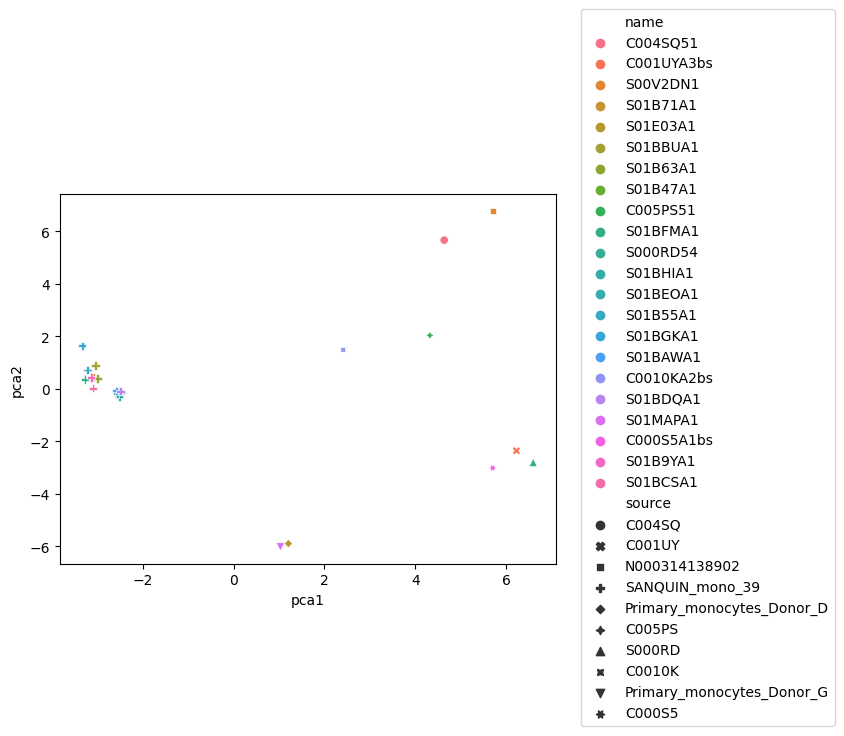

In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

col_names = ['pca1', 'pca2']
X_pca_df = pd.DataFrame(X_pca,columns=col_names)
X_pca_df['name'] = blueprint.index
X_pca_df.set_index(blueprint_source.index, inplace=True)
X_pca_df['source'] = blueprint_source['Name']
# plot the data points with colors based on the categories
sns.scatterplot(data=X_pca_df, x='pca1', y='pca2', style = 'source', hue='name' )
#plt.legend(bbox_to_anchor=(1.05, 1.2), loc='upper left')
# Set the legend to two rows
plt.legend(bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0., ncol=1)

#save the plot
plt.savefig('blueprint_pca_all_monocytes_average mathylation level.jpg', dpi=700,bbox_inches='tight', pad_inches=0.1)

plt.show()

## Final and Grail

In [ ]:
#grail = final.loc[final.index.str.contains('GSM')]
#grail.dropna(axis=1, inplace=True)

In [122]:
#only need for map output data
final = final.replace('.', np.nan).astype(float)
final.dropna(axis=1, inplace=True)

In [ ]:
final

In [131]:
X = final.iloc[:, 0:34891].values

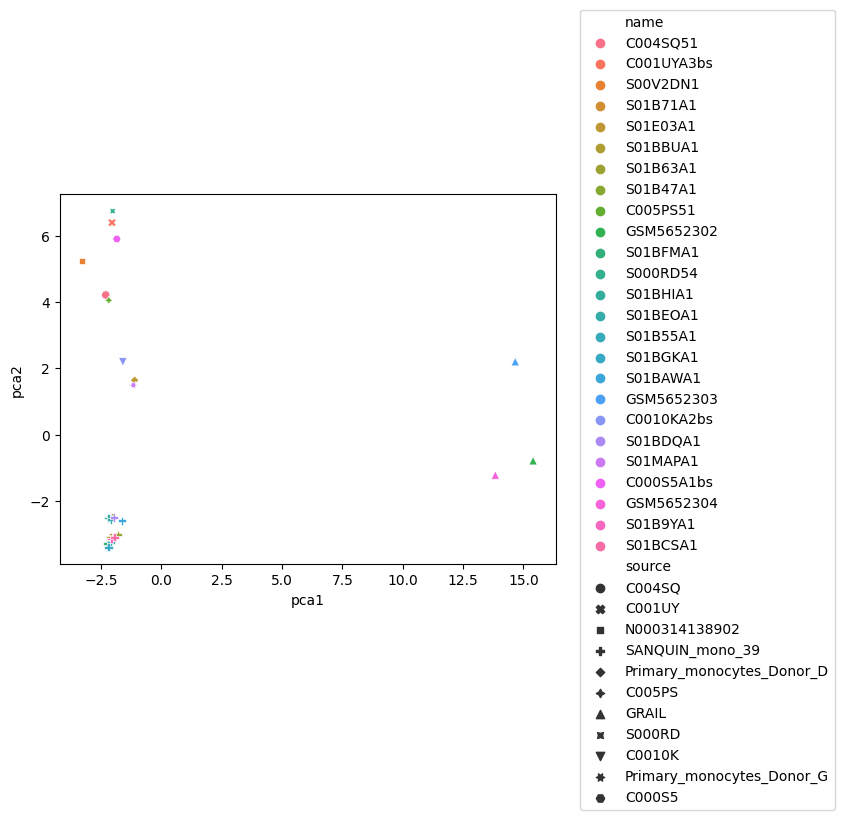

In [132]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
col_names = ['pca1', 'pca2']
X_pca_df = pd.DataFrame(X_pca,columns=col_names)
X_pca_df['name'] = final.index
X_pca_df.set_index(test.index, inplace=True)
X_pca_df['source'] = test['Name']
# plot the data points with colors based on the categories
sns.scatterplot(data=X_pca_df, x='pca1', y='pca2', style = 'source', hue='name' )
#plt.legend(bbox_to_anchor=(1.05, 1.2), loc='upper left')
# Set the legend to two rows
plt.legend(bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0., ncol=1)

#save the plot
plt.savefig('all_pca_all_monocytes_average methylation level.jpg', dpi=700,bbox_inches='tight', pad_inches=0.1)

plt.show()

## pairwise correlation

In [142]:
#only need for map data
final_ = final_.replace('.', np.nan).astype(float)

In [ ]:
final_

In [144]:
corr_matrix=final_.T.corr()

In [ ]:
corr_matrix

In [133]:
corr_matrix=final_.T.corr()
corr_matrix_=final.T.corr()

<ipython-input-133-e86e4de11d2d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=final_.T.corr()


In [ ]:
#unfiltered
corr_matrix
#filtered
corr_matrix_

In [147]:
corr_matrix['source'] = test['Name']
corr_matrix_['source'] = test['Name']

In [148]:
corr_matrix.to_csv('unfiltered_all_monocyte_average__pairwise_correlation_weighted.csv', index=True)
corr_matrix_.to_csv('filtered_all_monocyte_average__pairwise_correlation_weighted.csv', index=True)